In [1]:
# ====================================================
# Cell 1: Setup & Imports
# ====================================================
import os, glob
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import mlflow



In [2]:
mlflow.autolog()  # Enable MLflow autologging

2025/10/27 16:06:04 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [17]:
# Paths
BASE_PATH = r"D:\hack\impostor_detection\impostor_detection\data\raw\sapimouse\sapimouse"
PROCESSED_PATH = r"D:\hack\impostor_detection\impostor_detection\data\processed"

os.makedirs(PROCESSED_PATH, exist_ok=True)

# Collect user directories
user_dirs = sorted([p for p in os.listdir(BASE_PATH) if p.lower().startswith("user")])
print(f"Found {len(user_dirs)} users")

Found 120 users


In [72]:
# ====================================================
# Cell 2: Utility Functions
# ====================================================
def read_session_csv(path, user_id_from_folder):
    """Read session CSV robustly and return DataFrame with clean columns."""
    try:
        df = pd.read_csv(path, skipinitialspace=True, engine="python")
    except Exception:
        df = pd.read_csv(path, header=None, engine="python")

    if "client" not in df.columns and "client timestamp" not in df.columns:
        # fallback: assume order: ts, button, state, x, y
        df = df.rename(columns={df.columns[0]: "timestamp",
                                df.columns[1]: "button",
                                df.columns[2]: "state",
                                df.columns[3]: "x",
                                df.columns[4]: "y"})
        df["client"] = user_id_from_folder
    else:
        # If client timestamp present, split if needed
        if "client timestamp" in df.columns:
            s = df["client timestamp"].astype(str).str.split(r"\s+", n=1, expand=True)
            if s.shape[1] == 2:
                df["client"] = s[0]
                df["timestamp"] = pd.to_numeric(s[1], errors="coerce")
            else:
                df["client"] = user_id_from_folder
                df["timestamp"] = pd.to_numeric(s[0], errors="coerce")
            df = df.drop(columns=["client timestamp"])
        elif "timestamp" in df.columns:
            df["client"] = user_id_from_folder

    # Ensure numeric coords
    df["x"] = pd.to_numeric(df["x"], errors="coerce")
    df["y"] = pd.to_numeric(df["y"], errors="coerce")

    return df[["client","timestamp","button","state","x","y"]]

def _safe_series_stats(arr):
    """Return dict of basic stats for a 1D numeric array (may have NaNs)."""
    a = np.asarray(arr)
    a = a[np.isfinite(a)]
    if a.size == 0:
        return {"mean":0.0,"std":0.0,"skew":0.0,"kurt":0.0,"max":0.0,"min":0.0}
    return {
        "mean": float(np.mean(a)),
        "std": float(np.std(a, ddof=0)),
        "skew": float(pd.Series(a).skew()),
        "kurt": float(pd.Series(a).kurtosis()),
        "max": float(np.max(a)),
        "min": float(np.min(a)),
    }

def _shannon_entropy(arr, bins=8):
    arr = np.asarray(arr)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return 0.0
    hist, _ = np.histogram(arr, bins=bins, density=True)
    hist = hist[hist > 0]
    if hist.size == 0:
        return 0.0
    return float(-np.sum(hist * np.log2(hist)))
def extract_features(df, user_id):
    """
    Mouse-session feature extractor with both:
    - Duration-invariant behavioral features
    - Absolute movement/temporal signals (total distance, total duration, etc.)
    """
    df = df.sort_values("timestamp").reset_index(drop=True).copy()
    df["x"] = pd.to_numeric(df["x"], errors="coerce")
    df["y"] = pd.to_numeric(df["y"], errors="coerce")
    df["timestamp"] = pd.to_numeric(df["timestamp"], errors="coerce")

    n = len(df)
    if n < 4:
        return {"user_id": user_id, "valid": 0}

    state = df.get("state", pd.Series([""] * n)).astype(str).str.lower()
    pressed = state.isin(["pressed", "click", "mousedown"])
    released = state.isin(["released", "mouseup"])
    moved = state.isin(["move", "mousemove"])
    button = df.get("button", pd.Series([None] * n)).astype(str).str.lower()

    dx = df["x"].diff().fillna(0).to_numpy(dtype=float)
    dy = df["y"].diff().fillna(0).to_numpy(dtype=float)
    dt = df["timestamp"].diff().fillna(1).to_numpy(dtype=float)
    dt_safe = np.where(dt <= 0, np.nan, dt)

    step_dist = np.sqrt(dx**2 + dy**2)
    speed = step_dist / np.where(np.isnan(dt_safe), 1.0, dt_safe)
    accel = np.empty_like(speed); accel[:] = np.nan
    accel[1:] = (speed[1:] - speed[:-1]) / np.where(np.isnan(dt_safe[1:]), 1.0, dt_safe[1:])
    jerk = np.empty_like(accel); jerk[:] = np.nan
    jerk[2:] = (accel[2:] - accel[1:-1]) / np.where(np.isnan(dt_safe[2:]), 1.0, dt_safe[2:])

    # === ✅ Absolute temporal/spatial features ===
    total_time = float(np.nansum(dt_safe))
    total_distance = float(np.nansum(step_dist))
    total_displacement = float(
        np.sqrt((df["x"].iloc[-1] - df["x"].iloc[0])**2 + (df["y"].iloc[-1] - df["y"].iloc[0])**2)
    )
    displacement_ratio = total_displacement / (total_distance + 1e-8)
    mean_disp = float(np.nanmean(step_dist))
    std_disp = float(np.nanstd(step_dist))

    # === Angular features ===
    angles = np.degrees(np.arctan2(dy, dx))
    ang_diff = np.abs(np.diff(angles))
    ang_diff = np.where(ang_diff > 180, 360 - ang_diff, ang_diff)
    ang_speed = np.empty_like(ang_diff); ang_speed[:] = np.nan
    if ang_diff.size > 0 and dt_safe.size >= 2:
        ang_speed = ang_diff / np.where(np.isnan(dt_safe[1:len(ang_diff)+1]), 1.0, dt_safe[1:len(ang_diff)+1])

    # === Event-based metrics ===
    click_count = int((pressed | released).sum())
    click_rate = click_count / float(n)
    click_times = df.loc[pressed | released, "timestamp"].to_numpy(dtype=float)
    double_click_count = int(np.sum(np.diff(click_times) <= 300.0)) if click_times.size > 1 else 0
    scroll_up = int(np.sum(button.str.contains("scroll_up|wheel_up|wheel", na=False)))
    scroll_down = int(np.sum(button.str.contains("scroll_down|wheel_down|wheel", na=False)))

    # === Pause/idle metrics ===
    gaps = dt_safe[1:][np.isfinite(dt_safe[1:])]
    pause_mask = gaps > 0.2
    pause_count = int(np.sum(pause_mask))
    pause_median = float(np.median(gaps)) if gaps.size > 0 else 0.0
    pause_iqr = float(np.nanpercentile(gaps, 75) - np.nanpercentile(gaps, 25)) if gaps.size > 0 else 0.0
    idle_fraction_events = float(pause_count) / float(n)

    # === Hover stats ===
    small_move_mask = step_dist <= 5.0
    hover_durations, run_start = [], None
    for i, small in enumerate(small_move_mask):
        if small and run_start is None:
            run_start = i
        elif not small and run_start is not None:
            duration = np.nansum(dt_safe[run_start+1:i+1]) if i > run_start else 0.0
            hover_durations.append(float(duration if np.isfinite(duration) else 0.0))
            run_start = None
    if run_start is not None:
        duration = np.nansum(dt_safe[run_start+1:]) if run_start+1 < len(dt_safe) else 0.0
        hover_durations.append(float(duration if np.isfinite(duration) else 0.0))
    hover_count = len(hover_durations)
    hover_median = float(np.median(hover_durations)) if hover_durations else 0.0
    hover_std = float(np.std(hover_durations)) if hover_durations else 0.0

    # === Behavioral shape stats ===
    rt_count = 0
    K = 20
    for i in range(3, n):
        j_start = max(0, i - K)
        window = np.sqrt((df["x"].iloc[j_start:i-2].to_numpy(dtype=float) - df["x"].iloc[i])**2 +
                         (df["y"].iloc[j_start:i-2].to_numpy(dtype=float) - df["y"].iloc[i])**2)
        if np.any(window <= 5.0):
            rt_count += 1

    dx_sign = np.sign(dx)
    dy_sign = np.sign(dy)
    zigzag_score = int(np.sum(dx_sign[1:] * dx_sign[:-1] < 0) + np.sum(dy_sign[1:] * dy_sign[:-1] < 0))
    sharp_turns = int(np.sum(ang_diff > 90.0))
    curvature = float(np.nanmean(ang_diff)) if ang_diff.size > 0 else 0.0
    mean_abs_jerk = float(np.nanmean(np.abs(jerk[np.isfinite(jerk)]))) if np.any(np.isfinite(jerk)) else 0.0
    smoothness_index = float(1.0 / (mean_abs_jerk + 1e-8))
    sum_abs_dx, sum_abs_dy = float(np.sum(np.abs(dx))), float(np.sum(np.abs(dy)))
    lateral_vertical_ratio = float(sum_abs_dx / (sum_abs_dy + 1e-8))

    quadrants = np.zeros(4, dtype=int)
    for sx, sy in zip(dx, dy):
        if sx >= 0 and sy >= 0: quadrants[0] += 1
        elif sx < 0 and sy >= 0: quadrants[1] += 1
        elif sx < 0 and sy < 0: quadrants[2] += 1
        else: quadrants[3] += 1
    dominant_dir = int(np.argmax(quadrants))
    dominant_dir_frac = float(quadrants[dominant_dir] / max(1, np.sum(quadrants)))

    speed_stats = _safe_series_stats(speed)
    accel_stats = _safe_series_stats(accel)
    jerk_stats = _safe_series_stats(jerk)
    ang_stats = _safe_series_stats(ang_diff)
    speed_entropy = _shannon_entropy(speed, bins=8)
    angle_entropy = _shannon_entropy(ang_diff, bins=8)

    out = {
        "user_id": user_id,
        "valid": 1,
        "n_events": n,
        # === Duration-Invariant ===
        "click_rate": click_rate,
        "double_click_count": double_click_count,
        "scroll_up_count": scroll_up,
        "scroll_down_count": scroll_down,
        "pause_count": pause_count,
        "pause_median": pause_median,
        "pause_iqr": pause_iqr,
        "idle_fraction_events": idle_fraction_events,
        "hover_count": hover_count,
        "hover_median": hover_median,
        "hover_std": hover_std,
        "speed_mean": speed_stats["mean"],
        "speed_std": speed_stats["std"],
        "speed_max": speed_stats["max"],
        "accel_mean": accel_stats["mean"],
        "accel_std": accel_stats["std"],
        "jerk_mean": jerk_stats["mean"],
        "jerk_std": jerk_stats["std"],
        "angle_mean": ang_stats["mean"],
        "angle_std": ang_stats["std"],
        "sharp_turns": sharp_turns,
        "curvature": curvature,
        "angle_entropy": angle_entropy,
        "angular_speed_mean": float(np.nanmean(ang_speed)) if np.any(np.isfinite(ang_speed)) else 0.0,
        "return_to_origin_count": rt_count,
        "zigzag_score": zigzag_score,
        "smoothness_index": smoothness_index,
        "spatial_x_norm": float(np.nanstd(df["x"]) / (np.nanmean(df["x"]) + 1e-8)),
        "spatial_y_norm": float(np.nanstd(df["y"]) / (np.nanmean(df["y"]) + 1e-8)),
        "lateral_vertical_ratio": lateral_vertical_ratio,
        "dominant_dir": dominant_dir,
        "dominant_dir_frac": dominant_dir_frac,
        "speed_entropy": speed_entropy,
        "n_unique_positions": int(len(pd.DataFrame({"x": df["x"], "y": df["y"]}).drop_duplicates())),
        # === Absolute Motion/Temporal Features (added back) ===
        "total_time": total_time,
        "total_distance": total_distance,
        "total_displacement": total_displacement,
        "displacement_ratio": displacement_ratio,
        "mean_step_distance": mean_disp,
        "std_step_distance": std_disp,
    }

    # Clean NaNs/Infs
    for k, v in list(out.items()):
        if v is None or (isinstance(v, float) and (np.isnan(v) or np.isinf(v))):
            out[k] = 0.0
        if isinstance(out[k], (np.floating, np.integer)):
            out[k] = out[k].item()

    return out


In [73]:
# ====================================================
# Cell 3: Build Feature Tables
# ====================================================
def build_feature_table(session_list, label="1min"):
    rows = []
    for user, path in tqdm(session_list, desc=f"{label} sessions"):
        raw = read_session_csv(path, user)
        feats = extract_features(raw, user)
        feats["session_file"] = os.path.basename(path)
        rows.append(feats)
    return pd.DataFrame(rows)

# Collect files
all_1min, all_3min = [], []
for user in user_dirs:
    user_folder = os.path.join(BASE_PATH, user)
    for fpath in glob.glob(os.path.join(user_folder, "*.csv")):
        if "1min" in fpath.lower():
            all_1min.append((user, fpath))
        elif "3min" in fpath.lower():
            all_3min.append((user, fpath))

df_1min = build_feature_table(all_1min, "1min")
df_3min = build_feature_table(all_3min, "3min")

print("Shapes:", df_1min.shape, df_3min.shape)
display(df_1min.head())


3min sessions: 100%|██████████| 122/122 [02:19<00:00,  1.15s/it]

Shapes: (122, 44) (122, 44)


,user_id,valid,n_events,click_rate,double_click_count,scroll_up_count,scroll_down_count,pause_count,pause_median,pause_iqr,...,dominant_dir_frac,speed_entropy,n_unique_positions,total_time,total_distance,total_displacement,displacement_ratio,mean_step_distance,std_step_distance,session_file
0,user1,1,2055,0.049635,57,0,0,2052,17.0,1.0,...,0.368370,1.131646,1920,57346.0,38617.726413,571.056039,0.014787,18.792081,31.474638,session_2020_05_14_1min.csv
1,user10,1,1760,0.067045,64,0,0,1759,17.0,1.0,...,0.335795,1.019725,1608,59548.0,37444.983442,510.075485,0.013622,21.275559,35.468857,session_2020_05_14_1min.csv
2,user100,1,2512,0.066879,96,0,0,2507,17.0,2.0,...,0.361863,1.202294,2326,60718.0,54045.074824,676.854490,0.012524,21.514759,29.753721,session_2020_03_31_1min.csv
3,user101,1,1691,0.039622,34,0,0,1690,17.0,1.0,...,0.396807,0.796302,1605,60086.0,16718.778541,200.942778,0.012019,9.886918,16.600122,session_2020_06_08_1min.csv
4,user102,1,2236,0.075134,102,0,0,2233,17.0,1.0,...,0.347943,0.876738,2034,59624.0,41592.445983,687.873535,0.016538,18.601273,28.931799,session_2020_03_31_1min.csv


In [74]:
# ====================================================
# Cell 4: Standardization & Saving
# ====================================================
NUMERIC_COLS = [c for c in df_1min.columns if c not in ["user_id","session_file"]]

def save_versioned_csv(df, basename):
    """Save df to processed path with versioning."""
    v = 1
    while True:
        out_path = Path(PROCESSED_PATH) / f"{basename}_v{v}.csv"
        if not out_path.exists():
            break
        v += 1
    df.to_csv(out_path, index=False)
    print(f"Saved {out_path}")

# Standardize and save
scaler = StandardScaler()

if not df_1min.empty:
    df1_scaled = df_1min.copy()
    df1_scaled[NUMERIC_COLS] = scaler.fit_transform(df1_scaled[NUMERIC_COLS])
    save_versioned_csv(df1_scaled, "sapimouse_1min_features")

if not df_3min.empty:
    df3_scaled = df_3min.copy()
    df3_scaled[NUMERIC_COLS] = scaler.fit_transform(df3_scaled[NUMERIC_COLS])
    save_versioned_csv(df3_scaled, "sapimouse_3min_features")


Saved D:\hack\impostor_detection\impostor_detection\data\processed\sapimouse_1min_features_v4.csv
Saved D:\hack\impostor_detection\impostor_detection\data\processed\sapimouse_3min_features_v4.csv


In [3]:
df_1min=pd.read_csv(r"D:\hack\impostor_detection\impostor_detection\data\processed\sapimouse_1min_features_v4.csv")
df_3min=pd.read_csv(r"D:\hack\impostor_detection\impostor_detection\data\processed\sapimouse_3min_features_v4.csv")

In [4]:
# ====================================================
# Cell 5: Sanity Check
# ====================================================
print("1min summary stats:")
display(df_1min.describe().T)

print("3min summary stats:")
display(df_3min.describe().T)


1min summary stats:


,count,mean,std,min,25%,50%,75%,max
valid,122.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
n_events,122.0,-2.461601e-16,1.004124,-1.619867,-0.461609,-0.153284,0.183589,3.755971
click_rate,122.0,-5.337261e-16,1.004124,-2.706209,-0.576924,0.039345,0.653548,2.834273
double_click_count,122.0,2.329648e-16,1.004124,-2.404422,-0.877270,-0.024172,0.755202,2.608848
scroll_up_count,122.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
scroll_down_count,122.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
pause_count,122.0,2.011142e-16,1.004124,-1.697621,-0.460842,-0.130627,0.224027,3.975678
pause_median,122.0,-4.777599e-18,1.004124,-2.959595,0.224449,0.224449,0.224449,4.682111
pause_iqr,122.0,-4.845850e-17,1.004124,-0.846223,-0.154503,-0.154503,-0.154503,10.221297
idle_fraction_events,122.0,-7.133410e-16,1.004124,-9.058280,0.106811,0.142270,0.157576,0.170326


3min summary stats:


,count,mean,std,min,25%,50%,75%,max
valid,122.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
n_events,122.0,-7.826162e-17,1.004124,-1.355672,-0.471881,-0.179558,0.089704,5.902718
click_rate,122.0,-2.284147e-16,1.004124,-3.009578,-0.452125,0.014487,0.577214,2.856929
double_click_count,122.0,2.111244e-16,1.004124,-2.233980,-0.559218,-0.064837,0.598170,3.146721
scroll_up_count,122.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
scroll_down_count,122.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
pause_count,122.0,-8.008166e-17,1.004124,-1.549160,-0.505135,-0.163357,0.149717,3.937216
pause_median,122.0,-4.732098e-17,1.004124,-2.930516,0.222244,0.222244,0.222244,4.636108
pause_iqr,122.0,-2.204521e-16,1.004124,-2.596735,-0.196722,-0.196722,-0.196722,4.603303
idle_fraction_events,122.0,6.688639e-17,1.004124,-8.833300,0.109273,0.137918,0.157482,0.177079


In [5]:
# ====================================================
# Cell X: Train/Validation/Test split by user ranges (val:90-100, test:101-120)
# ====================================================
# This cell assumes `df_1min` and `df_3min` are already built in previous cells.
# We'll create df1_train/df1_val/df1_test and df3_train/df3_val/df3_test
VAL_USER_START = 91
VAL_USER_END = 104
TEST_USER_START = 105
TEST_USER_END = 120
# user ids in the data are strings like 'user100' or numeric; handle both
def normalize_user(u):
    if pd.isna(u):
        return None
    try:
        s = str(u).lower().strip().replace('user', '')
        return int(s)
    except Exception:
        # if it can't be converted, return None
        return None

# helper to split into train/val/test by numeric user ranges
def split_train_val_test_by_user_ranges(df, val_start, val_end, test_start, test_end, user_col='user_id'):
    df = df.copy()
    df['_user_num'] = df[user_col].apply(normalize_user)
    mask_val = df['_user_num'].between(val_start, val_end, inclusive='both')
    mask_test = df['_user_num'].between(test_start, test_end, inclusive='both')
    df_val = df[mask_val].drop(columns=['_user_num']).reset_index(drop=True)
    df_test = df[mask_test].drop(columns=['_user_num']).reset_index(drop=True)
    df_train = df[~(mask_val | mask_test)].drop(columns=['_user_num']).reset_index(drop=True)
    return df_train, df_val, df_test

# Ensure df_1min/df_3min exist; if not, try to load latest processed files
def load_latest_processed(prefix):
    pattern = str(Path(PROCESSED_PATH) / f"{prefix}_v*.csv")
    files = sorted(glob.glob(pattern), key=os.path.getmtime)
    if not files:
        return None
    return pd.read_csv(files[-1])

if 'df_1min' not in globals() or df_1min is None:
    df_1min = load_latest_processed('sapimouse_1min_features')
    if df_1min is None:
        raise RuntimeError('df_1min not found in memory and no processed file available')

if 'df_3min' not in globals() or df_3min is None:
    df_3min = load_latest_processed('sapimouse_3min_features')
    if df_3min is None:
        raise RuntimeError('df_3min not found in memory and no processed file available')

# perform splits (val: 90-100, test: 101-120)
df1_train, df1_val, df1_test = split_train_val_test_by_user_ranges(df_1min, VAL_USER_START, VAL_USER_END, TEST_USER_START, TEST_USER_END, user_col='user_id')
df3_train, df3_val, df3_test = split_train_val_test_by_user_ranges(df_3min, VAL_USER_START, VAL_USER_END, TEST_USER_START, TEST_USER_END, user_col='user_id')

# Print summaries
print('1min - train shape, unique users:', df1_train.shape, df1_train['user_id'].nunique())
print('1min - val shape, unique users:', df1_val.shape, df1_val['user_id'].nunique())
print('1min - test shape, unique users:', df1_test.shape, df1_test['user_id'].nunique())
print('Validation users in 1min val (sample):', sorted(df1_val['user_id'].unique())[:10])
print('Test users in 1min test (sample):', sorted(df1_test['user_id'].unique())[:10])

print('3min - train shape, unique users:', df3_train.shape, df3_train['user_id'].nunique())
print('3min - val shape, unique users:', df3_val.shape, df3_val['user_id'].nunique())
print('3min - test shape, unique users:', df3_test.shape, df3_test['user_id'].nunique())
print('Validation users in 3min val (sample):', sorted(df3_val['user_id'].unique())[:10])
print('Test users in 3min test (sample):', sorted(df3_test['user_id'].unique())[:10])

# quick asserts to ensure val/test splits contain only users in their respective ranges
def assert_users_in_range(df, start, end, user_col='user_id'):
    nums = pd.Series(df[user_col].apply(normalize_user)).dropna().unique().tolist()
    if len(nums) == 0:
        print('Warning: no numeric users found in dataframe')
        return
    bad = [u for u in nums if u < start or u > end]
    if bad:
        raise AssertionError(f'Found users outside expected range in selection: {bad[:5]}...')
    print(f'All {len(nums)} numeric users in selection are within {start}-{end}')

assert_users_in_range(df1_val, VAL_USER_START, VAL_USER_END)
assert_users_in_range(df3_val, VAL_USER_START, VAL_USER_END)
assert_users_in_range(df1_test, TEST_USER_START, TEST_USER_END)
assert_users_in_range(df3_test, TEST_USER_START, TEST_USER_END)

# expose variables to notebook namespace
globals().update({'df1_train': df1_train, 'df1_val': df1_val, 'df1_test': df1_test, 'df3_train': df3_train, 'df3_val': df3_val, 'df3_test': df3_test})
print('Done: created df1_train, df1_val, df1_test, df3_train, df3_val, df3_test')


1min - train shape, unique users: (92, 44) 90
1min - val shape, unique users: (14, 44) 14
1min - test shape, unique users: (16, 44) 16
Validation users in 1min val (sample): ['user100', 'user101', 'user102', 'user103', 'user104', 'user91', 'user92', 'user93', 'user94', 'user95']
Test users in 1min test (sample): ['user105', 'user106', 'user107', 'user108', 'user109', 'user110', 'user111', 'user112', 'user113', 'user114']
3min - train shape, unique users: (92, 44) 90
3min - val shape, unique users: (14, 44) 14
3min - test shape, unique users: (16, 44) 16
Validation users in 3min val (sample): ['user100', 'user101', 'user102', 'user103', 'user104', 'user91', 'user92', 'user93', 'user94', 'user95']
Test users in 3min test (sample): ['user105', 'user106', 'user107', 'user108', 'user109', 'user110', 'user111', 'user112', 'user113', 'user114']
All 14 numeric users in selection are within 91-104
All 14 numeric users in selection are within 91-104
All 16 numeric users in selection are within 1

In [6]:
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools

def _normalize_user_id(u):
    if pd.isna(u): return None
    s = str(u).lower().strip()
    if s.startswith("user"): s = s.replace("user","")
    try:
        return int(s)
    except:
        try: return int(float(s))
        except: return s  # fallback: keep string

def _index_usernums(df, user_col='user_id'):
    usernums = df[user_col].apply(_normalize_user_id).tolist()
    return usernums

def build_all_pairs(df1, df3,
                    user_col='user_id',
                    include_within=False,
                    include_df1_df1=False,
                    include_df3_df3=False,
                    max_total_pairs=None,
                    neg_sample_ratio=1.0,
                    random_state=None):
    """
    Build PAIRS dataset.

    - By default: returns ONLY CROSS pairs (df1 vs df3), with ALL positives (same user)
      and ALL negatives (different user).
    - include_within: if True and include_df1_df1/include_df3_df3 flags set, also include
      within-df pairs (exhaustive combinations per user) for df1 and/or df3.
    - max_total_pairs: optional global cap (after concatenation); if set, will keep the first
      max_total_pairs rows (no random sampling).
    - neg_sample_ratio: float in (0,1] controlling fraction of negative cross-pairs to keep.
      If 1.0 (default) keeps all negatives. If 0.5 keeps ~50% of negatives, sampled without replacement.
    - random_state: optional integer seed for reproducible negative sampling.

    Returns: X1 (rows from df1), X2 (rows from df3), y (Series: 1 same-user, 0 different-user)
    """

    a = df1.reset_index(drop=True).copy()
    b = df3.reset_index(drop=True).copy()
    nA, nB = len(a), len(b)
    if nA == 0 or nB == 0:
        raise ValueError("df1 and df3 must be non-empty.")

    # get normalized user lists (parallel to rows)
    a_users = _index_usernums(a, user_col)
    b_users = _index_usernums(b, user_col)

    # --- CROSS PAIRS (exhaustive) ---
    # create full index grid -> memory O(nA * nB) for index arrays; user asked for ALL so we do it
    ia = np.repeat(np.arange(nA, dtype=np.int64), nB)
    ib = np.tile(np.arange(nB, dtype=np.int64), nA)

    # vectorized user equality check
    a_users_arr = np.array(a_users, dtype=object)[ia]
    b_users_arr = np.array(b_users, dtype=object)[ib]
    same_mask = (a_users_arr == b_users_arr)

    # positive = same_mask True, negative = False
    pos_idx = np.where(same_mask)[0]
    neg_idx = np.where(~same_mask)[0]

    # build arrays of indices for cross pairs
    ia_cross = ia
    ib_cross = ib
    labels_cross = np.zeros(len(ia_cross), dtype=np.int8)
    labels_cross[pos_idx] = 1

    # If desired, we can split and keep ordering (positives then negatives) or keep this ordering.
    # We'll keep positives first (makes it easier to inspect), then negatives (optionally subsampled).

    # --- NEGATIVE SAMPLING (new) ---
    # neg_sample_ratio controls fraction of negatives to retain (between 0 and 1].
    if neg_sample_ratio is None:
        neg_sample_ratio = 1.0
    try:
        neg_sample_ratio = float(neg_sample_ratio)
    except Exception:
        neg_sample_ratio = 1.0

    if neg_sample_ratio <= 0:
        chosen_neg = np.array([], dtype=neg_idx.dtype)
    elif neg_sample_ratio >= 1.0 or len(neg_idx) == 0:
        chosen_neg = neg_idx
    else:
        keep_neg = int(np.floor(len(neg_idx) * neg_sample_ratio))
        if keep_neg <= 0:
            chosen_neg = np.array([], dtype=neg_idx.dtype)
        elif keep_neg >= len(neg_idx):
            chosen_neg = neg_idx
        else:
            rng = np.random.default_rng(random_state)
            chosen_neg = rng.choice(neg_idx, size=keep_neg, replace=False)
            # keep selection stable order for readability (optional)
            chosen_neg = np.sort(chosen_neg)

    perm_pos = pos_idx
    perm_neg = chosen_neg
    order = np.concatenate([perm_pos, perm_neg]) if len(perm_neg) > 0 else perm_pos

    ia_cross = ia_cross[order]
    ib_cross = ib_cross[order]
    labels_cross = labels_cross[order]

    # create DataFrames for cross pairs (X1 from df1, X2 from df3)
    X1_cross = a.iloc[ia_cross].reset_index(drop=True)
    X2_cross = b.iloc[ib_cross].reset_index(drop=True)
    y_cross = pd.Series(labels_cross, name='same_user').reset_index(drop=True)

    # --- OPTIONAL: include within-df exhaustive pairs ---
    X1_within_parts = []
    X2_within_parts = []
    y_within_parts = []

    if include_within:
        # df1-df1
        if include_df1_df1:
            # for each user, all combinations (i<j) within df1
            user_to_idxs = defaultdict(list)
            for i,u in enumerate(a_users):
                user_to_idxs[u].append(i)
            i_list, j_list, lbls = [], [], []
            for u, idxs in user_to_idxs.items():
                if len(idxs) < 2: continue
                # all ordered pairs? for Siamese you can do combinations (i,j)
                for (i,j) in itertools.combinations(idxs, 2):
                    i_list.append(i); j_list.append(j); lbls.append(1)
                    # also add reversed order if you want both directions:
                    i_list.append(j); j_list.append(i); lbls.append(1)
            if len(i_list):
                X1_within_parts.append(a.iloc[i_list].reset_index(drop=True))
                X2_within_parts.append(a.iloc[j_list].reset_index(drop=True))
                y_within_parts.append(pd.Series(lbls, name='same_user').reset_index(drop=True))

        # df3-df3
        if include_df3_df3:
            user_to_idxs = defaultdict(list)
            for i,u in enumerate(b_users):
                user_to_idxs[u].append(i)
            i_list, j_list, lbls = [], [], []
            for u, idxs in user_to_idxs.items():
                if len(idxs) < 2: continue
                for (i,j) in itertools.combinations(idxs, 2):
                    i_list.append(i); j_list.append(j); lbls.append(1)
                    i_list.append(j); j_list.append(i); lbls.append(1)
            if len(i_list):
                X1_within_parts.append(b.iloc[i_list].reset_index(drop=True))
                X2_within_parts.append(b.iloc[j_list].reset_index(drop=True))
                y_within_parts.append(pd.Series(lbls, name='same_user').reset_index(drop=True))

    # --- CONCATENATE everything ---
    # By default we only include cross pairs. If within parts exist, append them.
    X1_parts = [X1_cross]
    X2_parts = [X2_cross]
    y_parts = [y_cross]

    if X1_within_parts:
        X1_parts.extend(X1_within_parts)
        X2_parts.extend(X2_within_parts)
        y_parts.extend(y_within_parts)

    X1_final = pd.concat(X1_parts, ignore_index=True, sort=False)
    X2_final = pd.concat(X2_parts, ignore_index=True, sort=False)
    y_final = pd.concat(y_parts, ignore_index=True, sort=False)

    # optional global cap (keeps first rows deterministically)
    if max_total_pairs is not None and len(y_final) > max_total_pairs:
        X1_final = X1_final.iloc[:max_total_pairs].reset_index(drop=True)
        X2_final = X2_final.iloc[:max_total_pairs].reset_index(drop=True)
        y_final = y_final.iloc[:max_total_pairs].reset_index(drop=True)

    return X1_final, X2_final, y_final


In [ ]:
# ============================
# Cell Y (FIXED for all cross pairs): create pairwise datasets for Siamese training/testing
# ============================

print('Building train pairwise dataset (all cross pairs)...')
X1_train, X2_train, y_train = build_all_pairs(
    df1_train, df3_train,
    include_within=False,          # only cross pairs
    include_df1_df1=False,
    include_df3_df3=False,
    max_total_pairs=None,
    neg_sample_ratio=0.5
)

print('Building test pairwise dataset (all cross pairs)...')
X1_test, X2_test, y_test = build_all_pairs(
    df1_test, df3_test,
    include_within=False,
    include_df1_df1=False,
    include_df3_df3=False,
    max_total_pairs=None,
    neg_sample_ratio=1.0
)

# Build validation pairwise dataset (using df1_val & df3_val)
print('Building validation pairwise dataset (all cross pairs)...')
X1_val, X2_val, y_val = build_all_pairs(
    df1_val, df3_val,
    include_within=False,
    include_df1_df1=False,
    include_df3_df3=False,
    max_total_pairs=None,
    neg_sample_ratio=1.0
)

print('TRAIN pairs:', X1_train.shape, X2_train.shape, 'y:', y_train.shape)
print('TRAIN class balance:', y_train.value_counts().to_dict())
print('VAL pairs:', X1_val.shape, X2_val.shape, 'y:', y_val.shape)
print('VAL class balance:', y_val.value_counts().to_dict())
print('TEST pairs:', X1_test.shape, X2_test.shape, 'y:', y_test.shape)
print('TEST class balance:', y_test.value_counts().to_dict())


Building train pairwise dataset (all cross pairs)...
Building test pairwise dataset (all cross pairs)...
Building validation pairwise dataset (all cross pairs)...
TRAIN pairs: (2188, 44) (2188, 44) y: (2188,)
TRAIN class balance: {0: 2092, 1: 96}
VAL pairs: (196, 44) (196, 44) y: (196,)
VAL class balance: {0: 182, 1: 14}
TEST pairs: (256, 44) (256, 44) y: (256,)
TEST class balance: {0: 240, 1: 16}


In [26]:
# =============================================
# Cell: EDA / Data Validation for Siamese inputs
# =============================================
def eda_siamese_inputs(X1, X2, y, df_names=('X1', 'X2', 'y')):
    dfs = [X1, X2, y] if isinstance(y, (pd.DataFrame, pd.Series)) else [X1, X2, y]
    
    for df, name in zip(dfs, df_names):
        print(f"\n=== EDA for {name} ===")
        # Basic info
        if isinstance(df, pd.Series):
            print("Type: Series")
            print(f"Dtype: {df.dtype}")
            print(f"Length: {len(df)}")
        else:
            print("Type: DataFrame")
            print(df.info())
        
        # Null / NaN counts per column
        if isinstance(df, pd.DataFrame):
            null_counts = df.isna().sum()
            print("\nNull/NaN counts per column:")
            print(null_counts[null_counts > 0] if null_counts.sum() > 0 else "No nulls found")
        else:  # Series
            null_count = df.isna().sum()
            print(f"\nNull/NaN count: {null_count}")
        
        # Data type mismatches: check if object columns are actually numeric
        if isinstance(df, pd.DataFrame):
            for col in df.columns:
                if df[col].dtype == 'object':
                    # attempt to convert to numeric
                    converted = pd.to_numeric(df[col], errors='coerce')
                    num_invalid = converted.isna().sum()
                    if num_invalid > 0:
                        print(f"Warning: Column '{col}' has {num_invalid} non-numeric entries")
        elif df.dtype == 'object':
            converted = pd.to_numeric(df, errors='coerce')
            num_invalid = converted.isna().sum()
            if num_invalid > 0:
                print(f"Warning: Series '{name}' has {num_invalid} non-numeric entries")
        
        # Optional: basic descriptive stats
        if isinstance(df, pd.DataFrame):
            print("\nDescriptive statistics:")
            print(df.describe())
        elif isinstance(df, pd.Series) and np.issubdtype(df.dtype, np.number):
            print("\nDescriptive statistics:")
            print(df.describe())

# Usage:
eda_siamese_inputs(X1_train, X2_train, y_train, df_names=('X1_train', 'X2_train', 'y_train'))
# also inspect validation pairs
eda_siamese_inputs(X1_val, X2_val, y_val, df_names=('X1_val', 'X2_val', 'y_val'))
eda_siamese_inputs(X1_test, X2_test, y_test, df_names=('X1_test', 'X2_test', 'y_test'))



=== EDA for X1_train ===
Type: DataFrame
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2188 entries, 0 to 2187
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 2188 non-null   object 
 1   valid                   2188 non-null   float64
 2   n_events                2188 non-null   float64
 3   click_rate              2188 non-null   float64
 4   double_click_count      2188 non-null   float64
 5   scroll_up_count         2188 non-null   float64
 6   scroll_down_count       2188 non-null   float64
 7   pause_count             2188 non-null   float64
 8   pause_median            2188 non-null   float64
 9   pause_iqr               2188 non-null   float64
 10  idle_fraction_events    2188 non-null   float64
 11  hover_count             2188 non-null   float64
 12  hover_median            2188 non-null   float64
 13  hover_std               2188 non-null   float64
 14

In [27]:
# Drop non-numeric/object columns
cols_to_drop = ['user_id', 'session_file']

# Ensure validation/train/test pairframes exist
X1_train_numeric = X1_train.drop(columns=cols_to_drop)
X2_train_numeric = X2_train.drop(columns=cols_to_drop)

X1_val_numeric = X1_val.drop(columns=cols_to_drop)
X2_val_numeric = X2_val.drop(columns=cols_to_drop)

X1_test_numeric = X1_test.drop(columns=cols_to_drop)
X2_test_numeric = X2_test.drop(columns=cols_to_drop)


In [34]:
# =========================
# Cell 1: Siamese Network Architecture
# =========================
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K

# Input feature dimension
input_dim = X1_train_numeric.shape[1]

# Embedding/Encoder
from tensorflow.keras.regularizers import l1, l2, l1_l2

def create_encoder(input_dim, embedding_dim=64, reg_type="l1", reg_strength=1e-4):
    if reg_type == "l1":
        reg = l1(reg_strength)
    elif reg_type == "l2":
        reg = l2(reg_strength)
    elif reg_type == "elasticnet":
        reg = l1_l2(l1=reg_strength, l2=reg_strength * 0.5)
    else:
        reg = None

    inp = Input(shape=(input_dim,))
    x = Dense(128, activation='relu', kernel_regularizer=reg)(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(embedding_dim, activation=None, kernel_regularizer=reg)(x)
    x = Lambda(lambda t: K.l2_normalize(t, axis=1))(x)
    return Model(inp, x, name='encoder')


# Create shared encoder
encoder = create_encoder(input_dim, embedding_dim=64, reg_type="l1", reg_strength=1e-4)


# Siamese Inputs
input_a = Input(shape=(input_dim,), name='input_a')
input_b = Input(shape=(input_dim,), name='input_b')

# Encode both inputs
encoded_a = encoder(input_a)
encoded_b = encoder(input_b)

# Merge embeddings: absolute difference + optional element-wise multiplication
merge = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([encoded_a, encoded_b])
# Optional: can also concatenate multiplication: 
# merge = tf.keras.layers.Concatenate()([merge, encoded_a * encoded_b])

# Dense head
x = Dense(64, activation='relu')(merge)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Output layer
output = Dense(1, activation='sigmoid')(x)

# Build Siamese model
siamese_model = Model(inputs=[input_a, input_b], outputs=output)
siamese_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_a             │ (None, 42)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_b             │ (None, 42)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 64)        │     14,272 │ input_a[0][0],    │
│ (Functional)        │                   │            │ input_b[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 64)        │          0 │ encoder[0][0],    │
│                     │                   │            │ encoder[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      4,160 │ lambda_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_12[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 32)        │      2,080 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_13[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │         33 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,929 (81.75 KB)

 Trainable params: 20,481 (80.00 KB)

 Non-trainable params: 448 (1.75 KB)

In [35]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        eps = K.epsilon()
        y_pred = K.clip(y_pred, eps, 1. - eps)
        loss_pos = -alpha * (1 - y_pred)**gamma * K.log(y_pred)
        loss_neg = -(1 - alpha) * y_pred**gamma * K.log(1 - y_pred)
        return K.mean(y_true * loss_pos + (1 - y_true) * loss_neg)
    return focal_loss_fixed


In [36]:
# =========================
# Cell 2: Compilation with Class-Weighted Loss
# =========================
from tensorflow.keras.metrics import AUC
# Compute class weights manually
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {int(k): float(v) for k, v in zip(classes, weights)}
print("Class weights:", class_weight_dict)

# Use binary_crossentropy with class weights
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

siamese_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[AUC(name='auc'), 'Precision', 'Recall']
)


Class weights: {0: 0.5229445506692161, 1: 11.395833333333334}


In [31]:
# =========================
# Cell 3: Training with EarlyStopping
# =========================
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Callback to record minority-class metrics per epoch (train & val)
class MinorityClassMetrics(tf.keras.callbacks.Callback):
    """Compute precision/recall/f1 for the minority class each epoch on train & val.

    Stores results in .history dict with keys:
      'train_prec','train_rec','train_f1','val_prec','val_rec','val_f1'
    """
    def __init__(self, train_data, val_data=None, minority_label=1):
        super().__init__()
        self.train_data = train_data  # tuple: (inputs, y)
        self.val_data = val_data
        self.minority = minority_label
        self.history = {k: [] for k in ['train_prec','train_rec','train_f1','val_prec','val_rec','val_f1']}

    def _compute_metrics(self, y_true, y_pred):
        # y_true and y_pred are 1D arrays
        from sklearn.metrics import precision_recall_fscore_support
        try:
            p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, pos_label=self.minority, average='binary')
        except Exception:
            # fallback if metric computation fails (e.g., single-class present)
            p, r, f = 0.0, 0.0, 0.0
        return float(p), float(r), float(f)

    def on_epoch_end(self, epoch, logs=None):
        # Train metrics
        try:
            X_train_inputs, y_train = self.train_data
            y_train_prob = self.model.predict(X_train_inputs, verbose=0)
            y_train_pred = (y_train_prob >= 0.5).astype(int).ravel()
            p,r,f = self._compute_metrics(np.asarray(y_train).ravel(), y_train_pred)
        except Exception:
            p,r,f = 0.0,0.0,0.0
        self.history['train_prec'].append(p)
        self.history['train_rec'].append(r)
        self.history['train_f1'].append(f)

        # Val metrics (if provided)
        if self.val_data is not None:
            try:
                X_val_inputs, y_val = self.val_data
                y_val_prob = self.model.predict(X_val_inputs, verbose=0)
                y_val_pred = (y_val_prob >= 0.5).astype(int).ravel()
                vp, vr, vf = self._compute_metrics(np.asarray(y_val).ravel(), y_val_pred)
            except Exception:
                vp, vr, vf = 0.0,0.0,0.0
            self.history['val_prec'].append(vp)
            self.history['val_rec'].append(vr)
            self.history['val_f1'].append(vf)
        else:
            # keep lengths aligned
            self.history['val_prec'].append(0.0)
            self.history['val_rec'].append(0.0)
            self.history['val_f1'].append(0.0)

# Instantiate the callback with TRAIN and VAL data (numeric inputs already prepared above)
minority_cb = MinorityClassMetrics(
    train_data=([X1_train_numeric, X2_train_numeric], y_train),
    val_data=([X1_val_numeric, X2_val_numeric], y_val),
    minority_label=1
)

history = siamese_model.fit(
    [X1_train_numeric, X2_train_numeric], y_train,
    validation_data=([X1_val_numeric, X2_val_numeric], y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr, minority_cb],
    verbose=2,
)


2025/10/27 18:05:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd1d3794aca294e9bbe5fe01b127ebdf3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/10/27 18:05:21 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'list'>. Dataset logging skipped.
2025/10/27 18:05:21 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'
2025/10/27 18:05:21 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'list'>. Dataset logging skipped.
2025/10/27 18:05:21 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'


Epoch 1/100


35/35 - 8s - 231ms/step - Precision: 0.0672 - Recall: 0.8021 - auc: 0.6824 - loss: 0.6951 - val_Precision: 0.2222 - val_Recall: 0.2857 - val_auc: 0.5922 - val_loss: 0.6316 - learning_rate: 1.0000e-03
Epoch 2/100
Epoch 2/100


35/35 - 2s - 46ms/step - Precision: 0.0843 - Recall: 0.8750 - auc: 0.8211 - loss: 0.5687 - val_Precision: 0.1818 - val_Recall: 0.2857 - val_auc: 0.6036 - val_loss: 0.6142 - learning_rate: 1.0000e-03
Epoch 3/100
Epoch 3/100


35/35 - 1s - 32ms/step - Precision: 0.0972 - Recall: 0.9062 - auc: 0.8623 - loss: 0.4999 - val_Precision: 0.1786 - val_Recall: 0.3571 - val_auc: 0.6346 - val_loss: 0.6053 - learning_rate: 1.0000e-03
Epoch 4/100
Epoch 4/100


35/35 - 1s - 25ms/step - Precision: 0.1195 - Recall: 0.9688 - auc: 0.9006 - loss: 0.4475 - val_Precision: 0.1600 - val_Recall: 0.2857 - val_auc: 0.6321 - val_loss: 0.5831 - learning_rate: 1.0000e-03
Epoch 5/100
Epoch 5/100


35/35 - 1s - 25ms/step - Precision: 0.1382 - Recall: 0.9792 - auc: 0.9283 - loss: 0.3946 - val_Precision: 0.1852 - val_Recall: 0.3571 - val_auc: 0.6323 - val_loss: 0.5584 - learning_rate: 1.0000e-03
Epoch 6/100
Epoch 6/100


35/35 - 1s - 25ms/step - Precision: 0.1540 - Recall: 0.9688 - auc: 0.9575 - loss: 0.3334 - val_Precision: 0.2083 - val_Recall: 0.3571 - val_auc: 0.6358 - val_loss: 0.5299 - learning_rate: 1.0000e-03
Epoch 7/100
Epoch 7/100


35/35 - 1s - 25ms/step - Precision: 0.1760 - Recall: 0.9479 - auc: 0.9518 - loss: 0.3216 - val_Precision: 0.2353 - val_Recall: 0.2857 - val_auc: 0.6358 - val_loss: 0.4820 - learning_rate: 1.0000e-03
Epoch 8/100
Epoch 8/100


35/35 - 1s - 25ms/step - Precision: 0.1840 - Recall: 0.9792 - auc: 0.9563 - loss: 0.3080 - val_Precision: 0.2500 - val_Recall: 0.3571 - val_auc: 0.6374 - val_loss: 0.4418 - learning_rate: 1.0000e-03
Epoch 9/100
Epoch 9/100


35/35 - 1s - 24ms/step - Precision: 0.2175 - Recall: 0.9583 - auc: 0.9601 - loss: 0.2859 - val_Precision: 0.2273 - val_Recall: 0.3571 - val_auc: 0.6646 - val_loss: 0.4167 - learning_rate: 1.0000e-03
Epoch 10/100
Epoch 10/100
35/35 - 1s - 23ms/step - Precision: 0.2243 - Recall: 0.9792 - auc: 0.9751 - loss: 0.2490 - val_Precision: 0.2000 - val_Recall: 0.4286 - val_auc: 0.6442 - val_loss: 0.4240 - learning_rate: 1.0000e-03
Epoch 11/100
35/35 - 1s - 23ms/step - Precision: 0.2243 - Recall: 0.9792 - auc: 0.9751 - loss: 0.2490 - val_Precision: 0.2000 - val_Recall: 0.4286 - val_auc: 0.6442 - val_loss: 0.4240 - learning_rate: 1.0000e-03
Epoch 11/100


35/35 - 1s - 25ms/step - Precision: 0.2541 - Recall: 0.9792 - auc: 0.9808 - loss: 0.2219 - val_Precision: 0.2222 - val_Recall: 0.4286 - val_auc: 0.6609 - val_loss: 0.3996 - learning_rate: 1.0000e-03
Epoch 12/100
Epoch 12/100


35/35 - 1s - 24ms/step - Precision: 0.2651 - Recall: 0.9583 - auc: 0.9744 - loss: 0.2283 - val_Precision: 0.2143 - val_Recall: 0.4286 - val_auc: 0.6770 - val_loss: 0.3816 - learning_rate: 1.0000e-03
Epoch 13/100
Epoch 13/100


35/35 - 1s - 25ms/step - Precision: 0.2991 - Recall: 1.0000 - auc: 0.9863 - loss: 0.1864 - val_Precision: 0.1724 - val_Recall: 0.3571 - val_auc: 0.7007 - val_loss: 0.3733 - learning_rate: 1.0000e-03
Epoch 14/100
Epoch 14/100


35/35 - 1s - 24ms/step - Precision: 0.3176 - Recall: 0.9792 - auc: 0.9880 - loss: 0.1706 - val_Precision: 0.1818 - val_Recall: 0.2857 - val_auc: 0.6841 - val_loss: 0.3395 - learning_rate: 1.0000e-03
Epoch 15/100
Epoch 15/100


35/35 - 1s - 31ms/step - Precision: 0.3878 - Recall: 0.9896 - auc: 0.9891 - loss: 0.1520 - val_Precision: 0.1905 - val_Recall: 0.2857 - val_auc: 0.6984 - val_loss: 0.3394 - learning_rate: 1.0000e-03
Epoch 16/100
Epoch 16/100
35/35 - 1s - 31ms/step - Precision: 0.3837 - Recall: 0.9792 - auc: 0.9888 - loss: 0.1556 - val_Precision: 0.2400 - val_Recall: 0.4286 - val_auc: 0.7109 - val_loss: 0.3443 - learning_rate: 1.0000e-03
Epoch 17/100
35/35 - 1s - 31ms/step - Precision: 0.3837 - Recall: 0.9792 - auc: 0.9888 - loss: 0.1556 - val_Precision: 0.2400 - val_Recall: 0.4286 - val_auc: 0.7109 - val_loss: 0.3443 - learning_rate: 1.0000e-03
Epoch 17/100
35/35 - 1s - 24ms/step - Precision: 0.3676 - Recall: 0.9688 - auc: 0.9879 - loss: 0.1531 - val_Precision: 0.2000 - val_Recall: 0.5000 - val_auc: 0.6819 - val_loss: 0.4233 - learning_rate: 1.0000e-03
Epoch 18/100
35/35 - 1s - 24ms/step - Precision: 0.3676 - Recall: 0.9688 - auc: 0.9879 - loss: 0.1531 - val_Precision: 0.2000 - val_Recall: 0.5000 - val

2025/10/27 18:05:51 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'list'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2025/10/27 18:05:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/27 18:05:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/27 18:05:52 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/10/27 18:05:52 WARNING mlflow.tensorflow: You are saving a Te

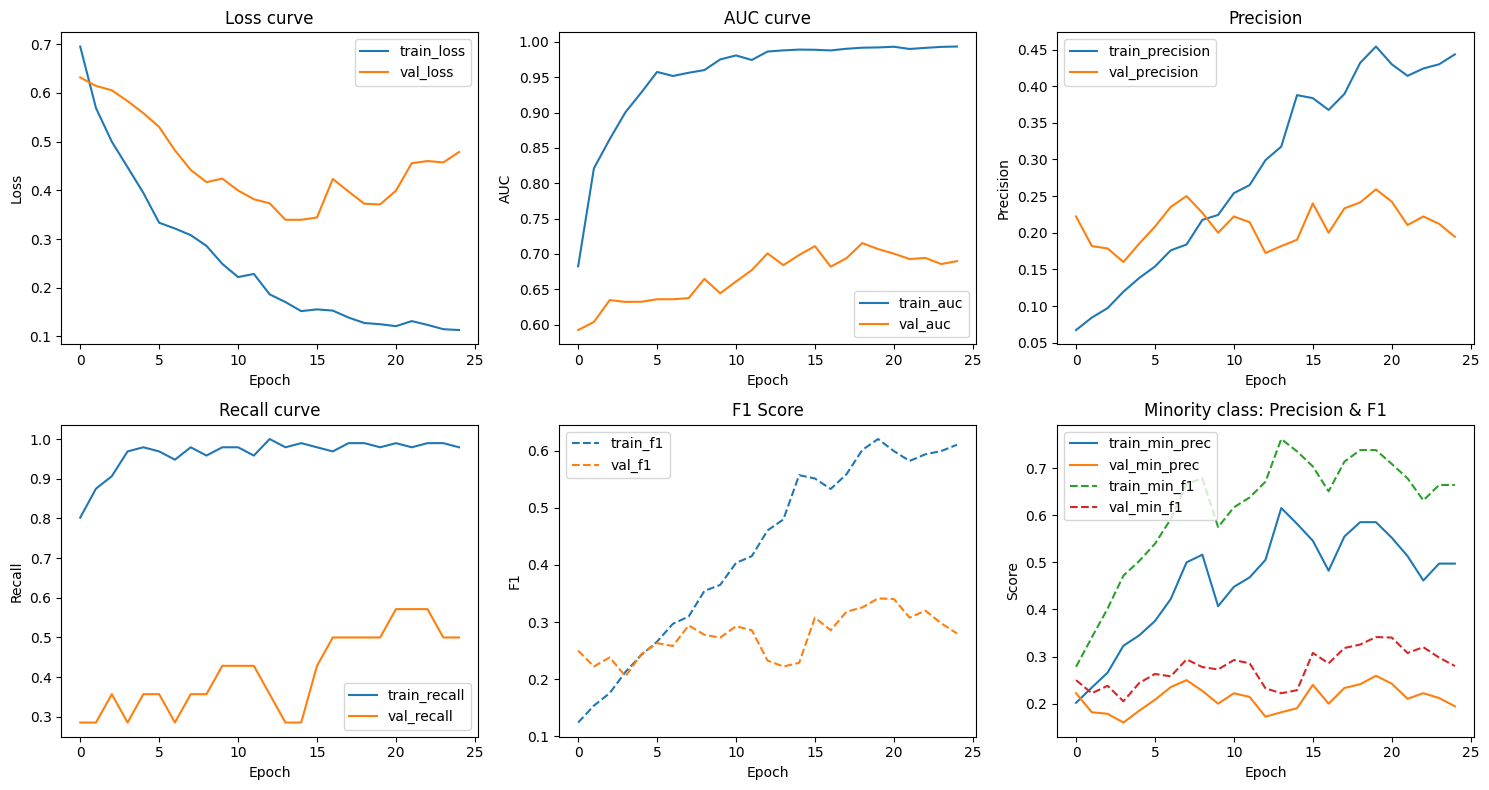

In [32]:
# =========================
# Cell 4: Plot Training Curves
# =========================
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15,8))

# helper to robustly find a metric key in history.history (handles case/val_ prefixes)
def _find_key(hist, base_name):
    base = base_name.lower()
    keys = list(hist.keys())
    # exact match (case-insensitive)
    for k in keys:
        if k.lower() == base:
            return k
    # val_ exact
    for k in keys:
        if k.lower() == f"val_{base}":
            return k
    # endswith match
    for k in keys:
        if k.lower().endswith(base):
            return k
    # contains
    for k in keys:
        if base in k.lower():
            return k
    return None

# find precision / recall keys for train & val
p_key = _find_key(history.history, 'precision')
r_key = _find_key(history.history, 'recall')
val_p_key = _find_key(history.history, 'val_precision') or (_find_key(history.history, 'precision') and f"val_{_find_key(history.history, 'precision')}")
val_r_key = _find_key(history.history, 'val_recall') or (_find_key(history.history, 'recall') and f"val_{_find_key(history.history, 'recall')}")

# fallback: try common Keras names if earlier lookup failed
if p_key is None:
    for candidate in ['Precision', 'precision']:
        if candidate in history.history:
            p_key = candidate
if r_key is None:
    for candidate in ['Recall', 'recall']:
        if candidate in history.history:
            r_key = candidate
# val fallbacks
if val_p_key is None and p_key is not None:
    val_p_key = 'val_' + p_key if ('val_' + p_key) in history.history else None
if val_r_key is None and r_key is not None:
    val_r_key = 'val_' + r_key if ('val_' + r_key) in history.history else None

# Extract arrays safely
train_loss = np.array(history.history.get('loss', []))
val_loss = np.array(history.history.get('val_loss', []))

auc_key = _find_key(history.history, 'auc')
train_auc = np.array(history.history.get(auc_key, [])) if auc_key in history.history else np.array([])
val_auc = np.array(history.history.get('val_' + auc_key, [])) if auc_key and ('val_' + auc_key) in history.history else np.array([])

train_prec = np.array(history.history.get(p_key, [])) if p_key in history.history else np.array([])
val_prec = np.array(history.history.get(val_p_key, [])) if val_p_key in history.history else np.array([])

train_rec = np.array(history.history.get(r_key, [])) if r_key in history.history else np.array([])
val_rec = np.array(history.history.get(val_r_key, [])) if val_r_key in history.history else np.array([])

# Compute F1 where precision & recall exist
eps = 1e-8
train_f1 = np.array([])
val_f1 = np.array([])
if train_prec.size and train_rec.size and train_prec.shape == train_rec.shape:
    train_f1 = 2 * (train_prec * train_rec) / (train_prec + train_rec + eps)
if val_prec.size and val_rec.size and val_prec.shape == val_rec.shape:
    val_f1 = 2 * (val_prec * val_rec) / (val_prec + val_rec + eps)

# ---- Plotting ----
# Layout: 2 rows x 3 cols so we can place Precision and F1 in separate subplots
plt.subplot(2,3,1)
plt.plot(history.history.get('loss', []), label='train_loss')
plt.plot(history.history.get('val_loss', []), label='val_loss')
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2,3,2)
# plot AUC if available
if train_auc.size:
    plt.plot(train_auc, label='train_auc')
if val_auc.size:
    plt.plot(val_auc, label='val_auc')
plt.title('AUC curve')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.subplot(2,3,3)
# Precision (its own subplot)
if train_prec.size:
    plt.plot(train_prec, label='train_precision')
if val_prec.size:
    plt.plot(val_prec, label='val_precision')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2,3,4)
# Recall (keep original)
if train_rec.size:
    plt.plot(train_rec, label='train_recall')
if val_rec.size:
    plt.plot(val_rec, label='val_recall')
plt.title('Recall curve')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2,3,5)
# F1 (separate subplot)
if train_f1.size:
    plt.plot(train_f1, label='train_f1', linestyle='--')
if val_f1.size:
    plt.plot(val_f1, label='val_f1', linestyle='--')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()

# Subplot (2,3,6): Minority-class performance (uses minority_cb.history recorded during training)
plt.subplot(2,3,6)
if 'minority_cb' in globals():
    t_prec = np.array(minority_cb.history.get('train_prec', []))
    v_prec = np.array(minority_cb.history.get('val_prec', []))
    t_f1 = np.array(minority_cb.history.get('train_f1', []))
    v_f1 = np.array(minority_cb.history.get('val_f1', []))
    # Plot precision and F1 for minority class
    if t_prec.size:
        plt.plot(t_prec, label='train_min_prec')
    if v_prec.size:
        plt.plot(v_prec, label='val_min_prec')
    if t_f1.size:
        plt.plot(t_f1, label='train_min_f1', linestyle='--')
    if v_f1.size:
        plt.plot(v_f1, label='val_min_f1', linestyle='--')
    plt.title('Minority class: Precision & F1')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
else:
    plt.text(0.1, 0.5, 'minority_cb not found\nRe-run training with minority callback', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Confusion Matrix:
 [[220  20]
 [  8   8]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9649    0.9167    0.9402       240
           1     0.2857    0.5000    0.3636        16

    accuracy                         0.8906       256
   macro avg     0.6253    0.7083    0.6519       256
weighted avg     0.9225    0.8906    0.9041       256

Confusion Matrix:
 [[220  20]
 [  8   8]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9649    0.9167    0.9402       240
           1     0.2857    0.5000    0.3636        16

    accuracy                         0.8906       256
   macro avg     0.6253    0.7083    0.6519       256
weighted avg     0.9225    0.8906    0.9041       256



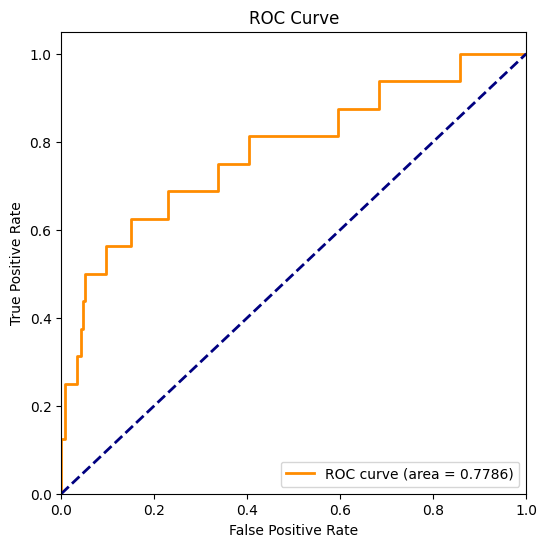

In [33]:
# =========================
# Cell 5: Evaluation Metrics
# =========================
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Predict probabilities
y_pred_prob = siamese_model.predict([X1_test_numeric, X2_test_numeric])
y_pred = (y_pred_prob >= 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Confusion Matrix:
 [[236   4]
 [  9   7]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9633    0.9833    0.9732       240
           1     0.6364    0.4375    0.5185        16

    accuracy                         0.9492       256
   macro avg     0.7998    0.7104    0.7459       256
weighted avg     0.9428    0.9492    0.9448       256

Confusion Matrix:
 [[236   4]
 [  9   7]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9633    0.9833    0.9732       240
           1     0.6364    0.4375    0.5185        16

    accuracy                         0.9492       256
   macro avg     0.7998    0.7104    0.7459       256
weighted avg     0.9428    0.9492    0.9448       256



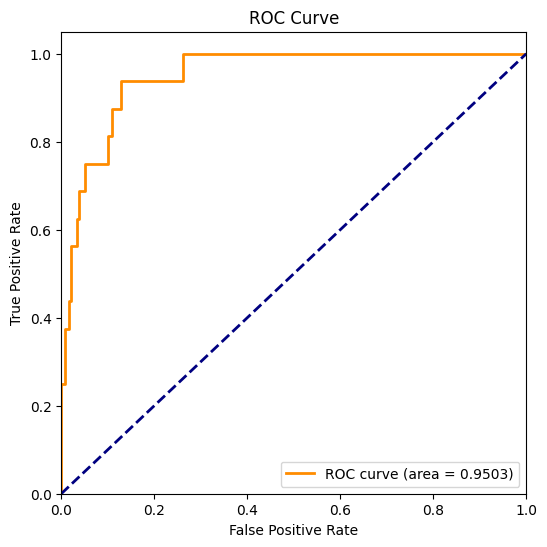

In [ ]:
# =========================
# Cell 5: Evaluation Metrics
# =========================
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Predict probabilities
y_pred_prob = siamese_model.predict([X1_test_numeric, X2_test_numeric])
y_pred = (y_pred_prob >= 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [4]:
mlflow ui --host 0.0.0.0 --port 5000


SyntaxError: invalid syntax (730469671.py, line 1)